In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
from datetime import datetime, date, timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df= pd.read_excel(r'C:\Users\basia\OneDrive\Pulpit\sdu shit\thesis\READY DATASETS\median.xlsx')
df.head()


,datetime,Origin,Day,Month,Week,Weekday,Hour,Minute,Price,Output
0,2022-01-01 15:00:00,1,1,1,1,1,15,0,349.0,55
1,2022-01-01 16:15:00,0,1,1,1,1,16,15,349.0,25
2,2022-01-02 07:00:00,1,2,1,1,2,7,0,399.0,44
3,2022-01-02 08:15:00,0,2,1,1,2,8,15,399.0,13
4,2022-01-02 15:15:00,1,2,1,52,6,15,15,399.0,25


In [3]:
df['Origin'] = df['Origin'].astype(float)
df['Week'] = df['Week'].astype(float)
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.dtypes)
train_data = df[df['datetime'] < '2022-10-01']
test_data = df[df['datetime'] >= '2022-10-01']



datetime    datetime64[ns]
Origin             float64
Day                  int64
Month                int64
Week               float64
Weekday              int64
Hour                 int64
Minute               int64
Price              float64
Output               int64
dtype: object


In [10]:
exogenous_features_train = train_data[['Origin', 'Day', 'Month', 'Week', 'Weekday', 'Hour', 'Minute', 'Price']]
exogenous_features_test = test_data[['Origin', 'Day', 'Month', 'Week', 'Weekday', 'Hour', 'Minute', 'Price']]
target_variable_train = train_data['Output']

In [11]:

from sklearn.preprocessing import MinMaxScaler
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the exogenous features
exogenous_features_train_scaled = scaler.fit_transform(exogenous_features_train)
exogenous_features_test_scaled = scaler.fit_transform(exogenous_features_test)
# Normalize the target variable
target_variable_scaled = scaler.fit_transform(target_variable.values.reshape(-1, 1))


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
# fit a SARIMAX model with exogenous variables on the training set
model = SARIMAX(train_data['Output'], order=(2, 1,0 ), seasonal_order=(0, 0, 2, 6), exog=train_data[['Origin', 'Weekday', 'Week',  'Month', 'Hour', 'Minute', 'Price']])
model_fit = model.fit()

# make predictions on the test set
test_data['predicted_demand'] = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_data[['Origin', 'Weekday', 'Week',  'Month', 'Hour', 'Minute', 'Price']])

# calculate the mean squared error
mse = mean_squared_error(test_data['Output'], test_data['predicted_demand'])

print('MSE:', mse)

C:\Users\basia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 91.42790190541074


C:\Users\basia\AppData\Local\Temp\ipykernel_12628\2644561757.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_demand'] = model_fit.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_data[['Origin', 'Weekday', 'Week',  'Month', 'Hour', 'Minute', 'Price']])


In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_data['Output'], test_data['predicted_demand']) #on average prediction is wrong about +- 7.5 seats purchased

7.421579360498308

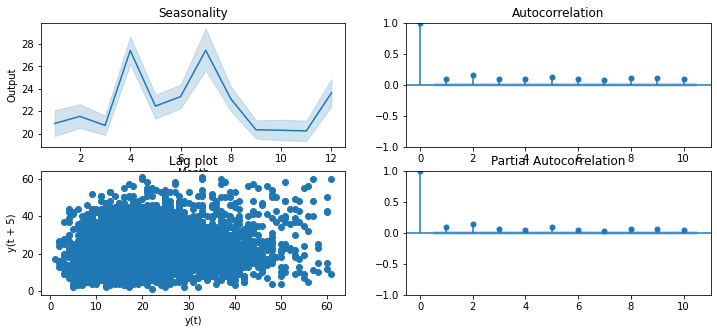

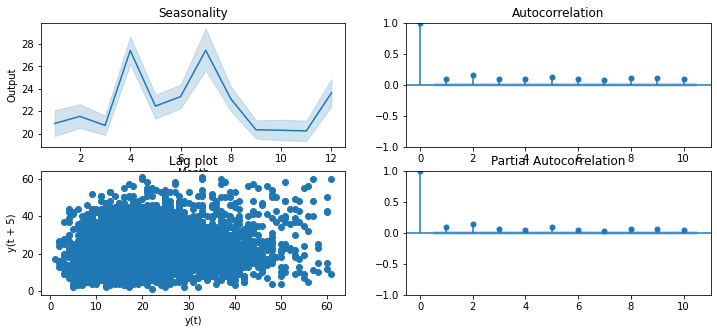

In [22]:
fig, ax = plt.subplots(2,2,figsize=(12,5))
sns.lineplot(x = 'Month', y = 'Output', data = df, ax=ax[0,0])
ax[0,0].set_title('Seasonality')
s = pd.Series(df['Output'])
pd.plotting.lag_plot(s, lag=5, ax=ax[1,0])
ax[1,0].set_title('Lag plot') #daily data is not really corrolated
plot_acf(df['Output'], lags=10, ax=ax[0,1]) #7 days observation period,flanctuations because of seasonality,  ACF decrease slowly when PACF rapidly (auto regression), ACF rapdily PACF slolwsly (moving avarage model), looking at lags that are out of norm: order of model (for Autoregression (p): at PACF, for moving avarage: for ACF (q)) 
plot_pacf(df['Output'], lags=10, ax=ax[1,1], method='ywm') 